In [3]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
#HYPERPARAMETERS

epochs = 10
batch_size = 8
margin = 1 # margin for contrastive loss

# Creating paths to appropriate images

In [5]:
class ContrastiveGenerator:
    def __init__(self, datasetPath, number_of_pairs):       #number_of_pairs : number of iterations in loop next_get_item()
        # empty list that will contain the subdirectory names of products
        # of the dataset directory with more than one image in it
        self.types_of_products = self.read_types_of_products(datasetPath)
        self.number_of_pairs = number_of_pairs
        # create a dictionary of people name to their image names
        self.allProducts = self.generate_all_products_dict()
        
    # The function below works correctly in 3 cases:
    # 1) images are only in subfolders 
    # 2) images are only in subsubfolders
    # 3) images are both in subfolders and subsubfolders
    def read_types_of_products(self, datasetPath) -> list[str]:
        # subdirectories in the main directory
        types = []
        subdirs_main = [d for d in os.listdir(datasetPath) if os.path.isdir(os.path.join(datasetPath,d))]
        #iterate over subdirectories in the main directory:
        for folderName in subdirs_main:
            subdirs_main_path = os.path.join(datasetPath, folderName)
            # subsubdirectories 
            subdirs = [d for d in os.listdir(subdirs_main_path) if os.path.isdir(os.path.join(subdirs_main_path,d))]
            # if there are no subsubdirectories, add the subdirectory name 
            if len(subdirs) == 0:
                types.append(subdirs_main_path)
            else:
                #traverse through all subsubdirectories and add them
                for directory in subdirs:
                    types.append(os.path.join(subdirs_main_path,directory)) 
        return types


    # Buildings paths to specific images
    def generate_all_products_dict(self):
        # create an empty dictionary that will be populated with
        # directory names as keys and image names as values
        all_products = dict()
        #populate with images
        for product in self.types_of_products:
            image_names = os.listdir(product)
            # build the image paths and populate the dictionary
            productsPhotos = [os.path.join(product, imageName) for imageName in image_names]
            all_products[product] = productsPhotos
        print(len(all_products))
        return all_products

    def get_next_element(self):
        for i in range(self.number_of_pairs):
            anchor = random.choice(self.types_of_products)

            # copy the list of products
            temporaryImages = self.types_of_products.copy()
            temporaryImages.remove(anchor)

            # random product from a list of products without anchor
            negativeProduct = random.choice(temporaryImages)

            (anchorProduct, positiveProduct) = np.random.choice(
                a=self.allProducts[anchor],
                size=2,
                replace=False
            )
            # Image from the negative folder
            negativeProduct = random.choice(self.allProducts[negativeProduct])


            yield (anchorProduct, positiveProduct, 0.0)
            yield (anchorProduct, negativeProduct, 1.0)

# Create object for creating dataset

In [6]:
path = r"/home/c100rczyk/VSCode/InsERT/Fruits"
# path = r"C:\Users\matim\Documents\Fruits360\archive\fruits-360_dataset\fruits-360\Training"
# path = r"C:\Users\matim\Documents\FruitDataset\archive"

number_of_pairs = 1000 #16   # WE Create number_of_pairs * 2  pairs.
generator = ContrastiveGenerator(path, number_of_pairs)

27


# Generator for creating dataset

In [8]:
dataset = tf.data.Dataset.from_generator( generator.get_next_element,
                                          output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.float32)))

In [9]:
print(dataset)

<_FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


# Creating dataset


In [10]:
IMAGE_SIZE = (258, 320)



def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def decode_resize_wrapper(image_path1, image_path2,value):
    # return tf.py_function(decode_and_resize, [image_path], tf.float32)
    img1 = decode_and_resize(image_path1)
    img2 = decode_and_resize(image_path2)
    return ((img1, img2), value)

def generate_new_pack_of_images():
    
    # Mapowanie funkcji na oba obrazy
    img_pack = dataset.map(lambda image_path1, image_path2, value: (decode_resize_wrapper(image_path1,image_path2,value)) )
    img_pack = img_pack.batch(batch_size)
    
    #print(list(img_pack))
    return img_pack




# Create new pack of images and labels

In [11]:
touple_of_products = generate_new_pack_of_images()
print(touple_of_products)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


## show and check if everything is ok ( how to get image from BatchDataset?? )

# In What form is our dataset and how to use it:
+ Our touple_of_products is Batchdataset.  ( (None,258,320,3) , (None, 258, 320,3), float32 )
+ First element is touple of "None" images. Where None is number of images in batch. In our case see on "batch_size"
+ So if for example batch_size = 8    we have  ( (8,258,320,3) , (8, 258,320,3), float32 )
+ Float32 is type of data of our labels. Each pair of images has own label  0-if same type,   1 - if different types of products

### Now if we get     for img1, label in touple_of_products:
img1 is touple of 2 touples : ( (8,258,320,3), (8,258,320,3) )
if we get img1[0] it means we get 8 images 
if we get img1[1] we also get 8 images

+ img1[0][x], img1[1][x],  label[x]  ,  if "x" is even(parzyste) we have same kind of labels
+ or
+ img1[0][x],  img1[1][x], label[x] ,  if "x" is odd (nieparzyste) we have different kind of labels

if we get for exp: img1[0][2] and img1[1][2]  than we also get label[2] 
we have pair of same kind of images.

number_of_pairs = 16
Then it is created 32 pairs (because on the return of get_next_element() there are 2 yields : one for positive pair and one for negative)

Because we have 32 pairs, and have specified batch_size = 8 :
+ we can get touples 4 times from touple_of_products (4*8 = 32)

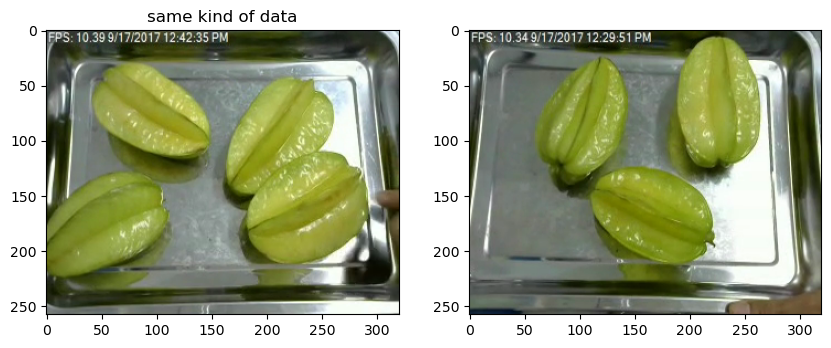

Etykieta: 0


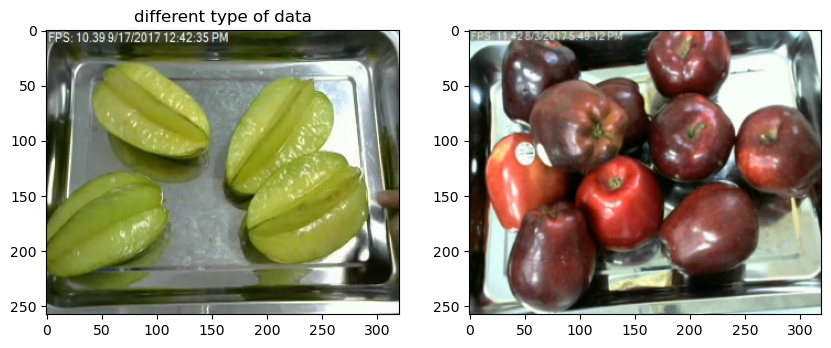

Etykieta: 1


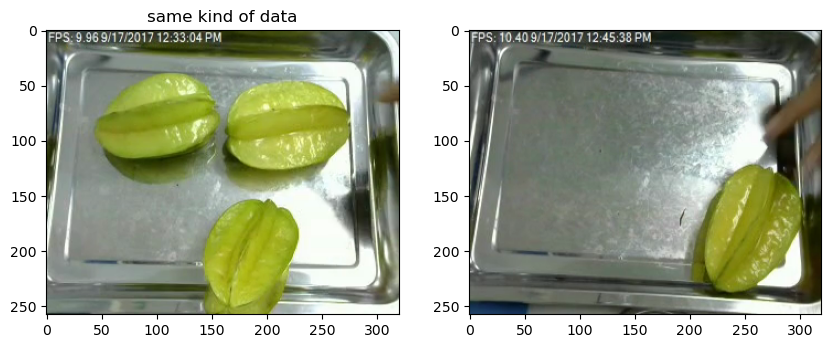

Etykieta: 0


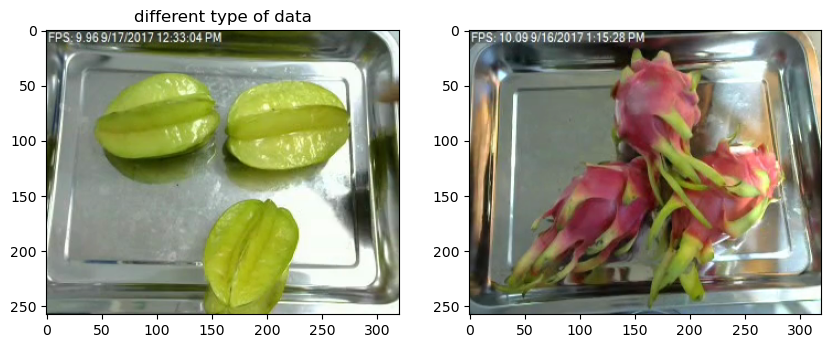

Etykieta: 1


In [13]:
# wyświetlenie obrazów:
import numpy
how_many_samples = 0

for img1, label in touple_of_products:
    if how_many_samples < 2:
        #print(img1)
        plt.figure(figsize=(10, 5))
        
        #-------------------------------------------------------
        plt.subplot(1, 2, 1)
        plt.imshow(np.asarray(img1[0][0]).astype('uint8'))
        plt.title('same kind of data')
        plt.subplot(1, 2, 2)
        plt.imshow(np.asarray(img1[1][0]).astype('uint8'))
        plt.title('')
        plt.show()
        print("Etykieta:", np.asarray(label[0]).astype('uint8'))
    
        #-------------------------------------------------------
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(np.asarray(img1[0][1]).astype('uint8'))
        plt.title('different type of data')
        plt.subplot(1, 2, 2)
        plt.imshow(np.asarray(img1[1][1]).astype('uint8'))
        plt.title('')
        plt.show()
        print("Etykieta:", np.asarray(label[1]).astype('uint8'))
        how_many_samples += 1

# Model for learn products distinguish

In [14]:
import keras

def euclidean_distance(vects):
    """
    Znalezienie odległości euklidesowej pomiędzy dwoma wektorami:

    Arguments:
        vects: Lista zawierające dwa tensory tej samej długości

    Returns:
        Tensor containing euclidean distance pomiędzy podanymi wektorami
    """
    x, y = vects

    sum_square = tf.reduce_sum(tf.square(x-y), axis=1, keepdims=True)   
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

input = keras.layers.Input((258,320,3))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(32, (5,5), activation="relu")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(64, (3,3), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(16, activation="relu")(x)
embedding_network = keras.Model(input, x)   # tworzę instancję modelu. Model nazywam embedding network
                                            # używam tego do dalszego definiowania modelu

input_1 = keras.layers.Input((258,320,3))
input_2 = keras.layers.Input((258,320,3))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])

normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

# Definition of loss function

In [15]:
def loss(margin=1):
    """
    Arguments: 
        margin: Integer, defines the baseline for distance for which pairs
        shoud be classified as dissimilar "1"
    Returns:
        tensor with contrastive loss as floating point value
    """
    # 0-same ,  1-different
    
    #contrastive_loss = (1-y_true)*

    def contrastive_loss(y_true, y_pred):
        """Calculate the contrastive loss
        Arguments:
            y_true: List of labels, each label is of type "float32"
            y_pred: List of predictions
            y_pred to przewidywane odległości między parami danych, które model stara się nauczyć
        Returns:
            A tensor containing contrastive loss value (folat)
        """
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - (y_pred), 0))
        return tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return contrastive_loss
    

## Compile model with contrastive loss


In [16]:
# Kompilacja modelu z contrastive_loss

siamese.compile(loss=loss(margin=margin), optimizer="adam", metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 258, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 258, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 16)           19830556    ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [17]:
# How many samples we have, and how many we want in train and validation
num_samples = sum(1 for _ in touple_of_products)
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
# .take() to get from actual batch
train_dataset = touple_of_products.take(train_size)
val_dataset = touple_of_products.skip(train_size)


Trained_model_data = siamese.fit(train_dataset, 
                                 validation_data= val_dataset, 
                                 batch_size = batch_size,
                                 epochs = epochs
                                )

Epoch 1/10


2024-04-05 22:44:46.065412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


    200/Unknown - 132s 652ms/step - loss: 0.2729 - accuracy: 0.5669

2024-04-05 22:46:58.110877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


200/200 [==============================] - 140s 692ms/step - loss: 0.2729 - accuracy: 0.5669 - val_loss: 0.2815 - val_accuracy: 0.5600
Epoch 2/10
200/200 [==============================] - 139s 693ms/step - loss: 0.2368 - accuracy: 0.6256 - val_loss: 0.2224 - val_accuracy: 0.6450
Epoch 3/10
200/200 [==============================] - 136s 680ms/step - loss: 0.2221 - accuracy: 0.6369 - val_loss: 0.2104 - val_accuracy: 0.6650
Epoch 4/10
200/200 [==============================] - 137s 685ms/step - loss: 0.2161 - accuracy: 0.6625 - val_loss: 0.1874 - val_accuracy: 0.7125
Epoch 5/10
200/200 [==============================] - 137s 687ms/step - loss: 0.2148 - accuracy: 0.6687 - val_loss: 0.1926 - val_accuracy: 0.7000
Epoch 6/10
200/200 [==============================] - 136s 680ms/step - loss: 0.2003 - accuracy: 0.6831 - val_loss: 0.1957 - val_accuracy: 0.6875
Epoch 7/10
200/200 [==============================] - 144s 720ms/step - loss: 0.2024 - accuracy: 0.7013 - val_loss: 0.1821 - val_accura

# Archiwum

In [235]:
# print(len(train_products_list))
# print(len(val_products_list))

# x_train_1 = []
# x_train_2 = []
# labels_train = []
# x_val_1 = []
# x_val_2 = []
# labels_val = []
# for (img1, img2), label in train_products_list:
#     x_train_1.append(img1)
#     x_train_2.append(img2)
#     labels_train.append(label)
# for (img1, img2), label in val_products_list:
#     x_val_1.append(img1)
#     x_val_2.append(img2)
#     labels_val.append(label)


# print(x_train_1)
# print(labels_train)